In [1]:
# import ipyparallel as ipp
from multiprocessing import Pool

import EEGAnalysis as ea
import h5py
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import re, os
from tqdm import tqdm


In [2]:
dataset = ea.DataManager('/home/yizhan/storage/EEG/Data')

patient_id = 'zhouchen'
patient = dataset.get_patient(patient_id)

In [3]:
# contants
_freq = 2000
ROI = (-3, 3)
tspec = np.linspace(ROI[0],ROI[1],_freq * (ROI[1] - ROI[0]))

nyq = _freq / 2.0
width = 5.0 / nyq
ripple_db = 60.0

# Compute the order and Kaiser parameter for the FIR filter.
N, beta = signal.kaiserord(ripple_db, width)

taps = signal.firwin(N, [0.5/nyq, 2/nyq],window=('kaiser', beta),pass_zero=False)

In [4]:
chidx = 4
data_list = patient.load_isplit(chidx)
data_list.keys()

dict_keys(['180827-1', '180827-2', '180827-3', '180829-1', '180829-2', '180829-3', '180831-1', '180831-2', '180831-3', '180901-1', '180901-2', '180901-3', '180902-1', '180902-2', '180902-3', '180903-1', '180903-2', '180903-3', '180904-1', '180904-2', '180904-3'])

In [ ]:
_temp = []
    for idate in data_list.keys():
        if idate[-1] != '3' or idate in ['190108-1', '190109-1']:
            continue

        _m = patient.get_marker(idate, paradigm='3-5')
        _entry = data_list[idate]['value']
        _filted = signal.hilbert(signal.filtfilt(taps, 1, _entry))
        _epoch = ea.create_1d_epoch_bymarker(_filted, _m, ROI, int(_freq))
        _temp.append(_epoch)
    _temp = np.array(_temp)

In [6]:
def _step_zhouchen(chidx):
    data_list = patient.load_isplit(chidx)

    _temp = []
    for idate in data_list.keys():
        if idate[-1] != '2' or idate in ['190108-1', '190109-1']:
            continue

        _m = patient.get_marker(idate, paradigm='2-5')
        _entry = data_list[idate]['value']
        _filted = signal.hilbert(signal.filtfilt(taps, 1, _entry))
        _epoch = ea.create_1d_epoch_bymarker(_filted, _m, ROI, int(_freq))
        _temp.append(_epoch)
    _temp = np.array(_temp)

    ##### #####
#     n = 5

#     plt.figure(figsize=(3*n,2))
#     for i in range(n):
#         _neo = _temp[:,i*(20//n):(i+1)*(20//n),:].reshape((7*20//n, -1))

#         entry_itpc = ea.decomposition.dwt_itpc(_neo.reshape((1,)+_neo.shape))

#         plt.subplot(1, n, i+1)
#         plt.plot(tspec, entry_itpc[0])
#         plt.ylim((0,1))
#         plt.xlim((tspec[0], tspec[-1]))
        
    ##### #####
    itpcs = []
    n = 5

    for each in _temp:
        _a = []
        for i in range(n):
            _neo = each[i*(20//n):(i+1)*(20//n),:].reshape((20//n, -1))
            entry_itpc = ea.decomposition.dwt_itpc(_neo.reshape((1,)+_neo.shape))
            _a.append(entry_itpc[0])

        itpcs.append(np.array(_a))
        
    itpcs = np.array(itpcs)
    
    plt.figure(figsize=(3*n,2))
    for i in range(n):
        _curve = np.mean(itpcs[:, i, :], 0)
        _sem = np.std(itpcs[:, i, :], 0) / np.size(itpcs, 0)

        plt.subplot(1, n, i+1)
        plt.plot(tspec, _curve)
        plt.fill_between(tspec, _curve-_sem, _curve+_sem, alpha=0.3)
        plt.plot(tspec, itpcs[:, i, :].T, c='k', alpha=0.1)

        plt.ylim((0,1))
    ##### #####
    

    plt.suptitle('channel: %d'%chidx)
    plt.savefig('./ITPC_seq_export/%s_avg_2/channel_%d.png'%(patient_id, chidx), bbox_inches='tight')
#     plt.show()
    plt.close()
    return _temp

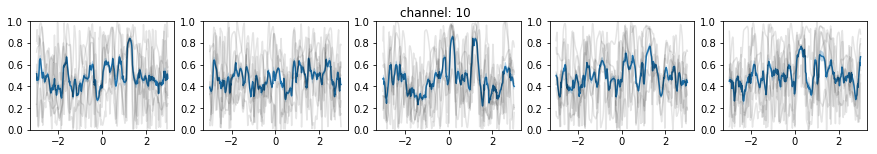

In [9]:
a = _step_zhouchen(10)

In [36]:
itpcs = []
n = 5

for each in a:
    _temp = []
    
    for i in range(n):
        _neo = each[i*(20//n):(i+1)*(20//n),:].reshape((20//n, -1))
        entry_itpc = ea.decomposition.dwt_itpc(_neo.reshape((1,)+_neo.shape))
        _temp.append(entry_itpc[0])
    
    itpcs.append(np.array(_temp))
itpcs = np.array(itpcs)

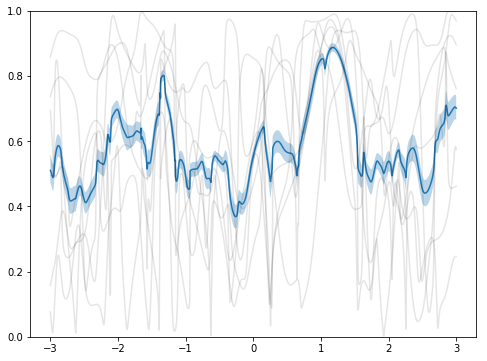

In [55]:
plt.figure(figsize=(8,6))
_curve = np.mean(itpcs[:, 0, :], 0)
_sem = np.std(itpcs[:, 0, :], 0) / np.size(itpcs, 0)

plt.plot(tspec, np.mean(itpcs[:, 0, :], 0))
plt.fill_between(tspec, _curve-_sem, _curve+_sem, alpha=0.3)
plt.plot(tspec, itpcs[:, 0, :].T, c='k', alpha=0.1)

plt.ylim((0,1))
plt.show()

In [ ]:
def _step(chidx):
    data_list = patient.load_isplit(chidx)

    _temp = []
    for idate in data_list.keys():
        if idate[-1] != '1' or idate in ['190108-1', '190109-1']:
            continue

        _m = patient.get_marker(idate)
        _entry = data_list[idate]['value']
        _filted = signal.hilbert(signal.filtfilt(taps, 1, _entry))
        _epoch = ea.create_1d_epoch_bymarker(_filted, _m, ROI, int(_freq))
        _temp.append(_epoch)
    _temp = np.array(_temp)

    n = 5

    plt.figure(figsize=(3*n,2))
    for i in range(n):
        _neo = _temp[:,20+i*(20//n):20+(i+1)*(20//n),:].reshape((5*20//n, -1))

        entry_itpc = ea.decomposition.dwt_itpc(_neo.reshape((1,)+_neo.shape))

        plt.subplot(1, n, i+1)
        plt.plot(entry_itpc[0])
        plt.ylim((0,1))
        plt.xlim((tspec[0], tspec[-1]))

    plt.suptitle('channel: %d'%chidx)
#     plt.savefig('./ITPC_seq_export/%s/channel_%d.png'%(patient_id, chidx), bbox_inches='tight')
    plt.show()
    plt.close()

In [7]:
with Pool(15) as p:
    max_ = 110
    a = list(tqdm(p.imap_unordered(_step_zhouchen, range(max_)), total=max_))

100%|██████████| 110/110 [08:54<00:00,  2.52s/it]


- [ ] 
- [ ] 不同范式下的phase比较
- [ ] 不同范式顺序下的区别。
- [ ] 不同通道的，脑区的平均，or 全脑？？？
- [ ] moving average
- [ ] 是否先打手来做分组的平均

- [ ] 不同脑区间的corr 